# Text analyses of all the tweets

In [ ]:
import json
import requests
import logging,sys
from getpass import getpass 
import os

## 1. Read in raw data and compile the tweet hashtags and tweets

In [ ]:
files = [f for f in os.listdir('.') if os.path.isfile(f)]
datfiles = [f for f in files if 'April' in f]
datfiles
#files in the current directory

In [ ]:
texts=[]
tag_list=[]
for fname in datfiles:
    print("Now we are processing data of", fname)
    with open(fname, 'r') as f:
        my_tweets = json.load(f)
    if my_tweets[-1] is None:
        del my_tweets[-1]
    for a_tweet in my_tweets:
        if 'lang' in a_tweet:
            if a_tweet['lang']!='en':  #filtering out all the non-english tweets
                continue
        if 'retweeted_status' in a_tweet: #filtering out retweets
            continue  
        if 'entities' in a_tweet:
            tag_list.append(a_tweet["entities"]["hashtags"])
        if 'extended_tweet' in a_tweet:
            texts.append(a_tweet["extended_tweet"]["full_text"]) #full text of truncated tweets
        elif 'text' in a_tweet:
            texts.append(a_tweet["text"])
        
    print("Now the texts length is", len(texts))

This results in 328,223 English tweets

## 2. Analyses of the hashtags

In this section, I am interested in knowing the occurences of all the hashtags in the tweets, and co-occurences of hashtags.

In [ ]:
tag_unigrams = []
tag_bigrams = []
tag_trigrams = []

for tags in tag_list:
    if len(tags) is 0:
        continue  
    a_tweet_tags = []
    a_tweet_bigrams=[]
    a_tweet_trigrams=[]
    for idx,tag in enumerate(tags):  # Enumerate returns a tuple: (index, object) for each object in the list
            a_tweet_tags.append(tag["text"].lower())
            for tag2 in tags[(idx+1):]:  # From (idx+1) to end--all later tags
                a_bigram = [tag["text"].lower(), tag2["text"].lower()]   # So they're all lowercase
                a_bigram.sort() 
                a_tweet_bigrams.append(tuple(a_bigram))
            for tag3 in tags[(idx+2):]:
                a_trigram = [tag["text"].lower(), tags[(idx+1)]["text"].lower(), tag3["text"].lower()]
                a_trigram.sort()
                a_tweet_trigrams.append(tuple(a_trigram))
    tag_unigrams.extend(set(a_tweet_tags)) #to make sure that repetitive hashtags in each tweet only appear once
    tag_bigrams.extend(set(a_tweet_bigrams)) 
    tag_trigrams.extend(set(a_tweet_trigrams)) 
    

In [ ]:
print(len(tag_unigrams))
print(len(tag_bigrams))
print(len(tag_trigrams))

In [ ]:
from collections import Counter

tag_count = Counter(tag_unigrams)
print(tag_count.most_common(20))
print("\n")
tag_bigram_count = Counter(tag_bigrams)
print(tag_bigram_count.most_common(10))
print("\n")
tag_trigram_count = Counter(tag_trigrams)
print(tag_trigram_count.most_common(10))

I wanted to delete all the items that are or contain #nationalsiblingsday, #nationalsiblingday, #siblingsday, and #siblingday, to make a better representation.

In [ ]:
exclude_list = ['nationalsiblingsday', 'nationalsiblingday', 'siblingsday', 'siblingday']
tag_unigrams_c = [tag for tag in tag_unigrams if tag not in exclude_list]
tag_count = Counter(tag_unigrams_c)
print(tag_count.most_common(15), "\n")

tag_bigrams_c = tag_bigrams
tag_trigrams_c = tag_trigrams
for excluded in exclude_list:
    tag_bigrams_c = [tagbi for tagbi in tag_bigrams_c if excluded not in tagbi]
    tag_trigrams_c = [tagtri for tagtri in tag_trigrams_c if excluded not in tagtri]
tag_bigram_count = Counter(tag_bigrams_c)
tag_trigram_count = Counter(tag_trigrams_c)
print(tag_bigram_count.most_common(15), "\n")
print(tag_trigram_count.most_common(15))

In [ ]:
'nationalsiblingsday' in ('fashion', 'nationalsiblingsday', 'tuesdaythoughts')

In [ ]:
from prettytable import PrettyTable



labels, counts = zip(*tag_count.most_common(15))

pt = PrettyTable()
pt.add_column("Single Hashtag", labels)
pt.add_column("Count", counts)

print(pt.get_html_string()) #print out html version of table, for ease of presentation on github

In [ ]:
from prettytable import PrettyTable



labels, counts = zip(*tag_bigram_count.most_common(15))

pt = PrettyTable()
pt.add_column("Hashtag Bigrams", labels)
pt.add_column("Count", counts)

print(pt.get_html_string()) #print out html version of table, for ease of presentation on github

In [ ]:
labels, counts = zip(*tag_trigram_count.most_common(15))

pt = PrettyTable()
pt.add_column("Hashtag", labels)
pt.add_column("Count", counts)

print(pt.get_html_string())

In [ ]:
[text for text in texts if '#equalpayday' in text.lower()][0:10]

In [ ]:
[text for text in texts if '#zuckerburg' in text.lower()][0:10]

In [ ]:
[text for text in texts if '#onlychild' in text.lower()][0:10]

In [ ]:
#store the irrelevant hashtags
irrel_hashtags = ['#equalpayday', '#tuesdaythoughts', '#lifecourbeeasier', '#zuckerberg', \
                  '#brochure', '#rack', '#flyer', '#roll',\
                 '#cbx_bloomingdays', '#felizmartes', '#temblor', '#mondaymotivation', \
                 '#americanidol', '#foodasitcom', '#michaelcohen', '#fcbsfc', '#fft18', '#michaelcohen',\
                 "#onlychild"]

## 3. Analyses of the tweet content - Ngrams

I am using the nltk package for analyses on the tweet content (i.e., text)

In [ ]:
#!conda install -y -c anaconda nltk
import nltk
#nltk.download("punkt")
#nltk.download("stopwords")
from nltk.collocations import ngrams
from nltk.corpus import stopwords
import urllib
import string

In [ ]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
tokens = [tknzr.tokenize(text) for text in texts]
tokens[0:2]

In [ ]:
from nltk.stem import SnowballStemmer
ss = SnowballStemmer("english")

In [ ]:
#clean the token list
clean_token_list = []
stem_word_lookup = {}

for tweet in tokens:
    clean_tweet = []
    for word in tweet:
        if word.startswith("htt") or word.startswith("@") or word.startswith("#") \
                            or word == "RT" \
                            or word in string.punctuation or word == "’" \
                            or word.lower() in stopwords.words('english'):   #this punctuation is not in the string punct list
            continue # Skip this one!
        else:
            stem = ss.stem(word)
            clean_tweet.append(stem)
            if not stem in stem_word_lookup.keys():
                stem_word_lookup[stem] = []
            if not word in stem_word_lookup[stem]:
                stem_word_lookup[stem].append(word)
    clean_token_list.append(clean_tweet)

In [ ]:
clean_token_list[-1]

In [ ]:
#combining all the tokens with sentinel indicating different tweets
clean_token_join=[]
for tokens in clean_token_list:
    clean_token_join.append(' '.join(tokens))

# Here's our sentinel word.
sentinel = 'LLLLLLLLL'
# For convenience, with spaces.
spaced_sentinel = ' ' + sentinel + ' '
combinedTokens=spaced_sentinel.join(clean_token_join).split()
print(clean_token_join[0:10])
combinedTokens[0:500]

Unigrams first.

In [ ]:
unigrams = [n for n in ngrams(combinedTokens,1) if sentinel not in n]
print(unigrams[0:20])
unigram_frequency = Counter([" ".join(gram) for gram in unigrams])

In [ ]:
unigram_frequency.most_common(50)

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(unigram_frequency)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Bigrams

In [ ]:
bigrams = [n for n in ngrams(combinedTokens,2) if sentinel not in n]
print(bigrams[0:20])
bigram_frequency = Counter([" ".join(gram) for gram in bigrams])

In [ ]:
bigram_frequency.most_common(50)

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(bigram_frequency)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Trigrams

In [ ]:
trigrams = [n for n in ngrams(combinedTokens,3) if sentinel not in n]
print(trigrams[0:20])
trigram_frequency = Counter([" ".join(gram) for gram in trigrams])

In [ ]:
trigram_frequency.most_common(50)

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(trigram_frequency)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.figure(figsize=(10,5))
plt.show()

## 4. Analyses of the tweet content - LDA Topic Modeling

Then I perform LDA topic modeling to the clean token list to figure out common topics.
I loop through 1 to 20 topics to obtain the model perplexity (lower is better) and the topic coherence (higher is better) of each topic model with certain number of topics predefined.

In [ ]:
#!conda install -y gensim 
from gensim import corpora
vocab = corpora.Dictionary(clean_token_list)
corpus = [vocab.doc2bow(tweet) for tweet in clean_token_list]
corpus[0:10]

In [ ]:
from gensim.models import ldamodel
from gensim.models import CoherenceModel

In [ ]:
tweet_lda = ldamodel.LdaModel(corpus, num_topics=5, id2word = vocab, passes = 20)

In [ ]:
tweet_lda.log_perplexity(corpus)

In [ ]:
CoherenceModel(model=tweet_lda, texts=clean_token_list,
                                        dictionary=vocab, coherence='c_v').get_coherence()

In [ ]:
perplexity = []
coherence = []
for i in range(1,21):
    tweet_lda = ldamodel.LdaModel(corpus, num_topics=i, id2word = vocab, passes = 20)
    perplexity.append(tweet_lda.log_perplexity(corpus))
    coherence.append(CoherenceModel(model=tweet_lda, texts=clean_token_list,
                                        dictionary=vocab, coherence='c_v').get_coherence())

In [ ]:
perplexity

In [ ]:
coherence

In [ ]:
fig1=plt.figure
plt.plot(range(1,21,1), perplexity)
plt.xticks(range(1,21,2))
plt.xlabel('Number of Topics')
plt.ylabel('Model Perplexity')
plt.savefig('LDA_perplexity.png')  
plt.show()  

In [ ]:
fig2=plt.figure
plt.plot(range(1,21), coherence)
plt.xticks(range(1,21,2))
plt.xlabel('Number of Topics')
plt.ylabel('Topic Coherence')
plt.savefig('LDA_coherence.png')  
plt.show()  

Based on output from perplexity and coherence, I decided to look into the 4-, 11-, and 20-topic models.

In [ ]:
#4-topic model
tweet_lda_4topic = ldamodel.LdaModel(corpus, num_topics=4, id2word = vocab, passes = 20)

In [ ]:
tweet_lda_4topic.print_topics(num_topics=4, num_words=10)

In [ ]:
topic3_list=['research', 'keyword', 'profession', 'market', 'competitor', 'digit']
topic3_text = [text for text in texts if any(word in text.lower() for word in topic3_list) \
               and not any(hashtag in text.lower() for hashtag in irrel_hashtags)]

In [ ]:
len(topic3_text)

In [ ]:
import random #for randomly picking example tweets
[ topic3_text[i] for i in sorted(random.sample(range(len(topic3_text)), 20)) ]

In [ ]:
topic3_list=['research', 'keyword', 'market','digit'] 

In [ ]:
#11-topic model
#tweet_lda_11topic = ldamodel.LdaModel(corpus, num_topics=11, id2word = vocab, passes = 20)

In [ ]:
#tweet_lda_11topic.print_topics(num_topics=11, num_words=10)

## 5. Analyses of the tweet content - Sentiment Analysis

In [ ]:
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

Before sentiment analyses, exclude all the irrelevant tweets that contained any of the irrelevant hashtags or keywords

In [ ]:
irrel_list=topic3_list+irrel_hashtags
texts_c = [text for text in texts if not any(word in text.lower() for word in irrel_list)]

In [288]:
len(texts_c)

128481

In [ ]:
compound = []
neg = []
pos = []
neu = []
for tweet in texts_c:
    scores=sid.polarity_scores(tweet)
    compound.append(scores.get("compound"))
    neg.append(scores.get("neg"))
    pos.append(scores.get("pos"))
    neu.append(scores.get("neu"))
    if len(compound)%5000==0:
        print(len(compound))

In [ ]:
len(compound) #make sure it's consistent with the texts list

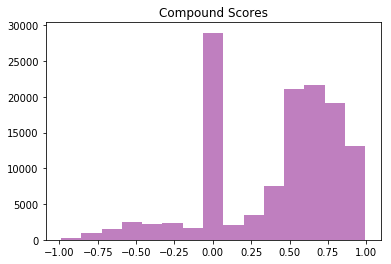

In [291]:
plt.hist(compound, 15, color="purple", alpha=.5)
plt.title("Compound Scores")
plt.savefig('sentiment_compound.png') 
plt.show()

In [ ]:
index_zero=[]
index_bitpos=[]
index_verypos=[]
index_neg=[]
for i in range(len(compound)):
    x=compound[i]
    if x==0:
        index_zero.append(i)
    if x>0 and x<.50:
        index_bitpos.append(i)
    if x>.50:
        index_verypos.append(i)
    if x<0:
        index_neg.append(i)

In [ ]:
print(len(index_zero))
print(len(index_bitpos))
print(len(index_verypos))
print(len(index_neg))

In [ ]:
tweet_zero=[texts[i] for i in index_zero]
tweet_bitpos=[texts[i] for i in index_bitpos]
tweet_verypos=[texts[i] for i in index_verypos]
tweet_neg=[texts[i] for i in index_neg]

In [ ]:
[ tweet_zero[i] for i in sorted(random.sample(range(len(tweet_zero)), 20)) ]

In [ ]:
[ tweet_bitpos[i] for i in sorted(random.sample(range(len(tweet_bitpos)), 20)) ]

In [ ]:
[ tweet_verypos[i] for i in sorted(random.sample(range(len(tweet_verypos)), 20)) ]

In [ ]:
[ tweet_neg[i] for i in sorted(random.sample(range(len(tweet_neg)), 20)) ]

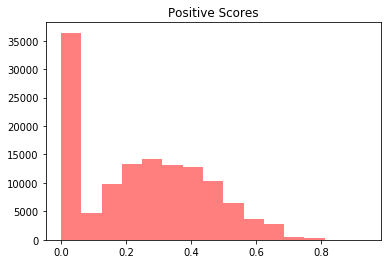

In [296]:
plt.hist(pos, 15, color="red", alpha=.5)
plt.title("Positive Scores")
plt.savefig('sentiment_pos.png') 
plt.show()

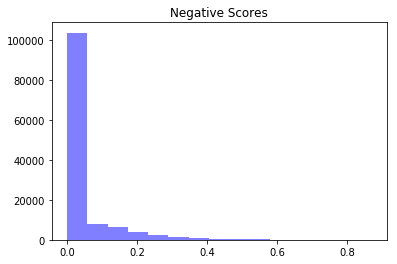

In [295]:
plt.hist(neg, 15, color="blue", alpha=.5)
plt.savefig('sentiment_neg.png')
plt.title("Negative Scores")
plt.show()

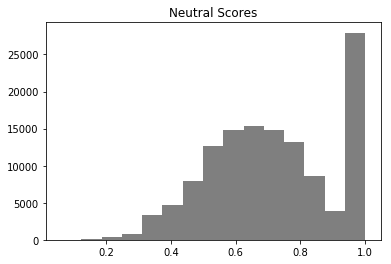

In [294]:
plt.hist(neu, 15, color="black", alpha=.5)
plt.title("Neutral Scores")
plt.savefig('sentiment_neu.png') 
plt.show()

In [ ]:
max(set(pos), key=compound.count) #find the mode

In [ ]:
mod(compound)